In [1]:
import sys, os

import torch
import numpy as np
import matplotlib.pyplot as plt
# torch.cuda.is_available = lambda : False

from torch import distributions as D
import pickle
from tqdm import tqdm
import tensorflow as tf

2025-02-02 22:39:12.365290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-02 22:39:12.378551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-02 22:39:12.382490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 22:39:12.395071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-02 22:39:14.158540: W tensorflow/compiler/tf2

In [13]:
elbo_mean = np.load('elbo_mean_fix_theta_lv_dense_oct10.npy')
all_times_arr = np.load('all_times_arr_fix_theta_lv_dense_oct10.npy', allow_pickle=True)
all_valid_times_arr = np.load('all_valid_times_arr_fix_theta_lv_dense_oct10.npy', allow_pickle=True)
all_steps = np.load('all_steps_fix_theta_lv_dense_oct10.npy', allow_pickle=True)
print(elbo_mean.shape, all_times_arr.shape, all_valid_times_arr.shape, all_steps.shape)

(500,) (149,) (500,) (149,)


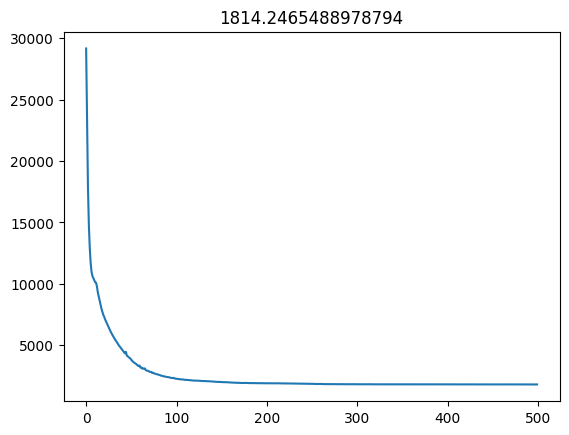

In [16]:
plt.plot(-elbo_mean)
plt.title(-elbo_mean[-1])
plt.show()

In [2]:
NP_DTYPE = np.float32 
f1 = open('./dat/our_files/fix_theta/LV_obs_partial_dense_test.txt', 'r')
f2 = open('./dat/our_files/fix_theta/LV_obs_binary_dense_test.txt', 'r')
f3 = open('./dat/our_files/fix_theta/LV_time_till_dense_test.txt', 'r')

obs = np.loadtxt(f1, NP_DTYPE)
obs_not_observed = np.log(1 + np.exp(-2)) + 1.0 #f(x) = 1 + softplus(x-1) for obs=-1
print('obs_not_observed:', obs_not_observed)
obs[obs==-1] = obs_not_observed
obs_bin = np.loadtxt(f2, NP_DTYPE)
time_till = np.loadtxt(f3, NP_DTYPE)
f1.close()
f2.close()
f3.close()

print('obs:', obs.shape) #(2,151)
print('obs_bin:', obs_bin.shape) #(2,151)
print('time_till:', time_till.shape) #(2,151)

obs_not_observed: 1.1269280110429727
obs: (2, 154624)
obs_bin: (2, 154624)
time_till: (2, 154624)


In [3]:
obs_pad_store = [] #l', 62+2pT
feat_window = 10
no_flows = 3
kernel_len = 20
flow_dims = 2
obs_flatten = np.reshape(obs, -1, 'F') #2pT
# print(obs_flatten[2*0:2*(0+151)].shape)
for i in range(0, feat_window*5, 5):
    pad_ext = no_flows * kernel_len + flow_dims
    # print(pad_ext)
    # print(np.zeros(pad_ext - i).shape)
    # print(np.zeros(i).shape)
    num_batches = 1024
    batch_len = 151
    obs_arr = np.zeros((num_batches, 2*batch_len+pad_ext))
    for j in range(num_batches):
        obs_arr[j] = np.concatenate((np.zeros(pad_ext - i), obs_flatten[2*j:2*(j+batch_len)], np.zeros(i)), axis=0)
    obs_pad_store.append(obs_arr)

(1024, 364)


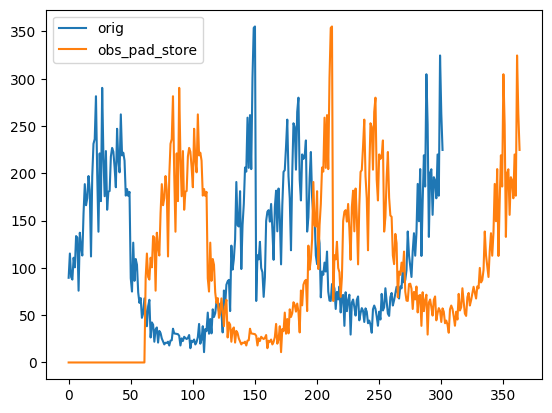

In [4]:
print(obs_pad_store[0].shape)

plt.plot(obs_flatten[:151*2], label='orig')
plt.plot(obs_pad_store[0][0][:], label='obs_pad_store')
plt.legend()
plt.show()

(2, 154624)
(2, 1024, 151)


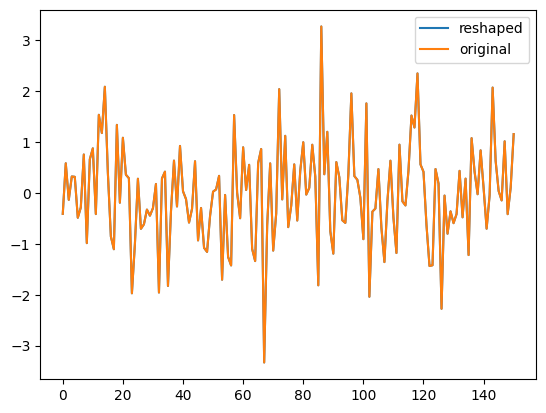

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [5]:
time_till_tmp = np.random.randn(2, 151*1024)
print(time_till_tmp.shape)
time_till_reshape = np.reshape(time_till_tmp, (2, 1024, 151))
print(time_till_reshape.shape)
plt.plot(time_till_reshape[0,0,:], label='reshaped')
plt.plot(time_till_tmp[0,:151], label='original')
plt.legend()
plt.show()
time_till_reshape[0,0,:]==time_till_tmp[0,:151]

In [6]:
# Example data
data = np.array(obs_pad_store).transpose(1,2,0)
print(data.shape)

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(data)

# Create batches of size 3
batched_dataset = dataset.batch(128)
num_batches = tf.data.experimental.cardinality(batched_dataset).numpy()
print('num_batches:', num_batches)
# Iterate over the batched dataset
for batch in batched_dataset:
    print(batch.shape)
    print((batch.numpy().shape))
    break

(1024, 364, 10)
num_batches: 8
(128, 364, 10)
(128, 364, 10)


2025-02-02 22:39:28.101338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46084 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:39:00.0, compute capability: 8.6
2025-02-02 22:39:28.102392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46084 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:3c:00.0, compute capability: 8.6
2025-02-02 22:39:28.103304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46084 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:cb:00.0, compute capability: 8.6
2025-02-02 22:39:28.103810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46084 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:cc:00.0, 

In [11]:
print((int(num_batches)))
print(int(tf.data.experimental.cardinality(batched_dataset)))

8
8


In [6]:
a = np.random.randn(2, 5*3)
b = np.reshape(a, -1, 'F')
print(a)
print(b)
print(b.shape)
no_flows = 3
kernel_len = 20
flow_dims = 2
# obs_flatten = np.reshape(obs, -1, 'F')
# print(obs_flatten.shape)
obs_pad_store = [] #l', 62+2pT
for i in range(0, 10*5, 5):
    obs_pad_store.append(np.concatenate(
        (np.zeros(50 - i), b, np.zeros(i)), axis=0))
print(obs_pad_store[0].shape)
print(obs_pad_store[0])

[[-1.05466786 -0.79614157  0.7064537   0.89982666 -1.35742753 -0.84988284
   1.13681454  0.65678708  1.35404795  0.02015532 -1.13330588 -0.17641199
  -0.75259598 -0.64320204  0.71216263]
 [ 1.06958231 -0.06831438 -0.11598131  0.94030753 -1.39405226  0.50237345
  -2.08698227  1.18586542  1.26860959 -0.92612303 -2.67151404  0.47672302
   1.12220105 -0.39905497 -0.78594059]]
[-1.05466786  1.06958231 -0.79614157 -0.06831438  0.7064537  -0.11598131
  0.89982666  0.94030753 -1.35742753 -1.39405226 -0.84988284  0.50237345
  1.13681454 -2.08698227  0.65678708  1.18586542  1.35404795  1.26860959
  0.02015532 -0.92612303 -1.13330588 -2.67151404 -0.17641199  0.47672302
 -0.75259598  1.12220105 -0.64320204 -0.39905497  0.71216263 -0.78594059]
(30,)
(80,)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.

In [7]:
print(154624/151)

a = np.arange(0, 4).reshape(2,2)
print(a)
b = np.broadcast_to(a, (2,*a.shape))
# b = (a.reshape(10,-1))
print(b)
print(b.shape)
# c = np.random.randn(2,4,3)
# d = c.transpose(1,0,2)
# print(d.shape)

1024.0
[[0 1]
 [2 3]]
[[[0 1]
  [2 3]]

 [[0 1]
  [2 3]]]
(2, 2, 2)


(1, 2, 152)


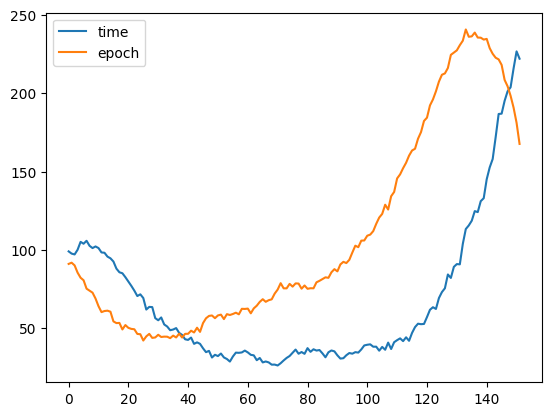

In [16]:
path = '/home/mmotame1/gmvi/ryder_run/VIforSSMs/dat/our_files/fix_theta/out_sparse/series_0_learned_lf_sample_0.npy'
t = np.load(path)
print(t.shape)
plt.plot(t[0,1], label='time')
plt.plot(t[0,0], label='epoch')
plt.legend()
plt.show()

In [4]:
T = 30
dt = 0.2
c = 1.0
fix_obs_scale = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 47
batch_size = 9216
load_dir = 'dat/our_files/fix_theta'

In [5]:
torch.manual_seed(seed)
np.random.seed(seed)
# data_file = '{}/exp01_dense_test.pt'.format(load_dir)
data_file = '{}/exp04_theta_test.pt'.format('.')
theta, x, y, y_idx = torch.load(data_file)
y_dict = {'theta': theta,
          'y': y,
          'y_idx': y_idx}
batch_size = theta.shape[0]

/tmp/ipykernel_2984083/2074554898.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta, x, y, y_idx = torch.load(data_file)


In [6]:
theta.shape, x.shape, y.shape, y_idx.shape

(torch.Size([1024, 4]),
 torch.Size([1024, 151, 2]),
 torch.Size([1024, 151, 2]),
 torch.Size([1024, 151]))

In [7]:
def save_obs_files(y, y_idx, out_dir='.', mode='theta_test'):
    T = 30
    dt = 0.2
    batch_size = int((T/dt) + 1) #151
    num_batch = y_idx.shape[0] #1024
    N = num_batch * batch_size
    print('num_batch:', num_batch)
    print('N:', N)
    print('batch_size:', batch_size)

    data_all = np.zeros((2,N))
    time_till_all = np.zeros((2,N))
    obs_bins_all = np.ones((2,N))

    for i in tqdm(range(num_batch)):
        obs_bins = np.ones((2, batch_size))
        time_till = np.zeros((2, batch_size)) - 1
        data = y.detach().cpu().numpy()[i,:].T
        obs_bins[data==0] = 0
        obs_locs = np.where(obs_bins[0]==1)[0]
        data[obs_bins==0] = -1
        for j in range(batch_size):
            next_locs = obs_locs[obs_locs>j]
            if len(next_locs) > 0:
                time_till[:,j] = next_locs[0] - j
            else:
                time_till[:,j] = 0 ## setting 0 for no more observations
        time_till *= dt
        data_all[:,i*batch_size:(i+1)*batch_size] = data
        time_till_all[:,i*batch_size:(i+1)*batch_size] = time_till
        obs_bins_all[:,i*batch_size:(i+1)*batch_size] = obs_bins
        
    np.savetxt(os.path.join(out_dir, f'LV_obs_partial_{mode}.txt'), data_all.astype(np.float32))
    np.savetxt(os.path.join(out_dir, f'LV_obs_binary_{mode}.txt'), obs_bins_all.astype(np.float32))
    np.savetxt(os.path.join(out_dir, f'LV_time_till_{mode}.txt'), time_till_all.astype(np.float32))

save_obs_files(y, y_idx)

num_batch: 1024
N: 154624
batch_size: 151


100%|██████████| 1024/1024 [00:01<00:00, 760.97it/s]
